# Прогнозирование температуры стали в процессе обработки

### Задача:
Разработка модели машинного обучения для прогнозирования конечной температуры стали в процессе обработки с целью оптимизации потребления электроэнергии.
### Цель:
Создать надежную и точную модель, способную предсказывать конечную температуру стали на основе данных о процессе обработки, включая параметры электродов, сыпучих и проволочных материалов, продувки газом, и начальных измерений температуры. Это позволит оптимизировать потребление электроэнергии и снизить производственные расходы.
### Вывод:
Модель LightGBM Regressor с оптимизированными гиперпараметрами показала наилучшую производительность с MAE 5.788 (константная 7.882) на обучающей выборке и 6.328 (константная 8.684) на тестовых данных.
### Данные:
Проект использует семь наборов данных, содержащих информацию о различных аспектах процесса обработки стали:
* data_arc: данные об электродах
* data_bulk: данные о подаче сыпучих материалов (объем)
* data_bulk_time: данные о подаче сыпучих материалов (время)
* data_gas: данные о продувке сплава газом
* data_temp: результаты измерения температуры
* data_wire: данные о проволочных материалах (объем)
* data_wire_time: данные о проволочных материалах (время)

### Метрики:
Основной метрикой для оценки производительности модели является средняя абсолютная ошибка (MAE).

### Краткое описание проекта:
1. Подготовка данных:
    * Импортируются необходимые библиотеки, такие как pandas, numpy, seaborn, matplotlib, lightgbm и shap.
    * Загружаются семь наборов данных, связанных с электродами, сыпучими материалами, продувкой газа, измерениями температуры и проволочными материалами.
    * Данные исследуются на наличие пропущенных значений, аномалий и распределений.
2. Исследовательский анализ данных:
    * Каждый набор данных анализируется индивидуально для определения его характеристик.
    * Визуализации, такие как гистограммы и ящики с усами, используются для понимания распределения данных и выявления потенциальных выбросов.
    * Столбец key, представляющий номер партии, проверяется на соответствие в разных наборах данных.
3. Предобработка данных:
    * Выявляются и удаляются аномалии, такие как отрицательная реактивная мощность и экстремально низкие температуры.
    * Обрабатываются пропущенные значения, в основном путем заполнения нулями.
    * Создаются новые признаки, такие как коэффициент мощности, затраченная энергия и продолжительность процесса.
    * Наборы данных объединяются в один датафрейм на основе столбца key.
4. Моделирование:
    * Предобработанные данные разделяются на обучающие и тестовые выборки.
    * Обучаются и сравниваются три модели: регрессия Ridge, регрессия ElasticNet и LightGBM.
    * RandomizedSearchCV используется для оптимизации гиперпараметров каждой модели.
5. Оценка и важность признаков:
    * Производительность каждой модели оценивается с использованием средней абсолютной ошибки (MAE).
    * LightGBM показывает наилучшую производительность с MAE 5.788 на обучающей выборке и 6.328 на тестовых данных.
    * Анализ важности признаков проводится с использованием встроенного графика важности признаков LightGBM и значений SHAP, выделяя значимость потребления энергии, начальной температуры и активной мощности.
6. Заключение и отчет:
    * Создана прогностическая модель для температуры стали с хорошей способностью к обобщению.
    * Отчет суммирует проект, включая этапы предобработки данных, выбор модели, важность признаков и потенциальные области для улучшения.


## Подготовка данных

In [ ]:
!pip install lightgbm --quiet
!pip install shap --quiet

In [ ]:
# загрузим библоитеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import  train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
SEED = 140823 # задали RANDOM STATE по условию заказчика

In [ ]:
# загрузим датасеты

data_arc = pd.read_csv('data_arc_new.csv')  # данные об электродах
data_bulk = pd.read_csv('data_bulk_new.csv')  # данные о подаче сыпучих материалов (объём)
data_bulk_time = pd.read_csv('data_bulk_time_new.csv')  # данные о подаче сыпучих материалов (время);
data_gas = pd.read_csv('data_gas_new.csv')  # данные о продувке сплава газом
data_temp = pd.read_csv('data_temp_new.csv') # результаты измерения температуры
data_wire = pd.read_csv('data_wire_new.csv') # данные о проволочных материалах (объём)
data_wire_time = pd.read_csv('data_wire_time_new.csv')  #  данные о проволочных материалах (время)

## Исследовательский анализ данных

### Data_arc

In [ ]:
# выведем общую информацию по таблице
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
# посмотрим описание
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [ ]:
# проверим на дубликаты
data_arc.duplicated().sum()

0

In [ ]:
# приведем колонку с датой в норм вид и посчитаем длительность нагрева
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc['delta_time'] = (data_arc.loc[data_arc['Реактивная мощность'] > 0,'Конец нагрева дугой'] -
                          data_arc.loc[data_arc['Реактивная мощность'] > 0, 'Начало нагрева дугой']).dt.total_seconds()
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,delta_time
5573,1210,2019-06-18 06:15:02,2019-06-18 06:16:10,0.761918,0.542666,68.0
12206,2652,2019-08-16 08:54:55,2019-08-16 08:56:06,0.320120,0.204227,71.0
12758,2771,2019-08-20 19:57:55,2019-08-20 19:59:19,0.882813,0.717992,84.0
1558,334,2019-05-16 10:34:40,2019-05-16 10:35:56,1.109344,0.912056,76.0
12840,2791,2019-08-21 12:17:45,2019-08-21 12:23:56,0.735337,0.516410,371.0
3503,759,2019-06-02 04:54:13,2019-06-02 05:00:13,0.362600,0.272670,360.0
10297,2236,2019-08-01 03:50:00,2019-08-01 03:51:34,0.886921,0.609950,94.0
10859,2363,2019-08-05 10:08:49,2019-08-05 10:10:25,0.449005,0.326225,96.0
5830,1269,2019-06-20 10:56:45,2019-06-20 11:00:01,0.937671,0.661512,196.0
7295,1583,2019-07-01 23:02:02,2019-07-01 23:04:00,0.860506,0.604216,118.0


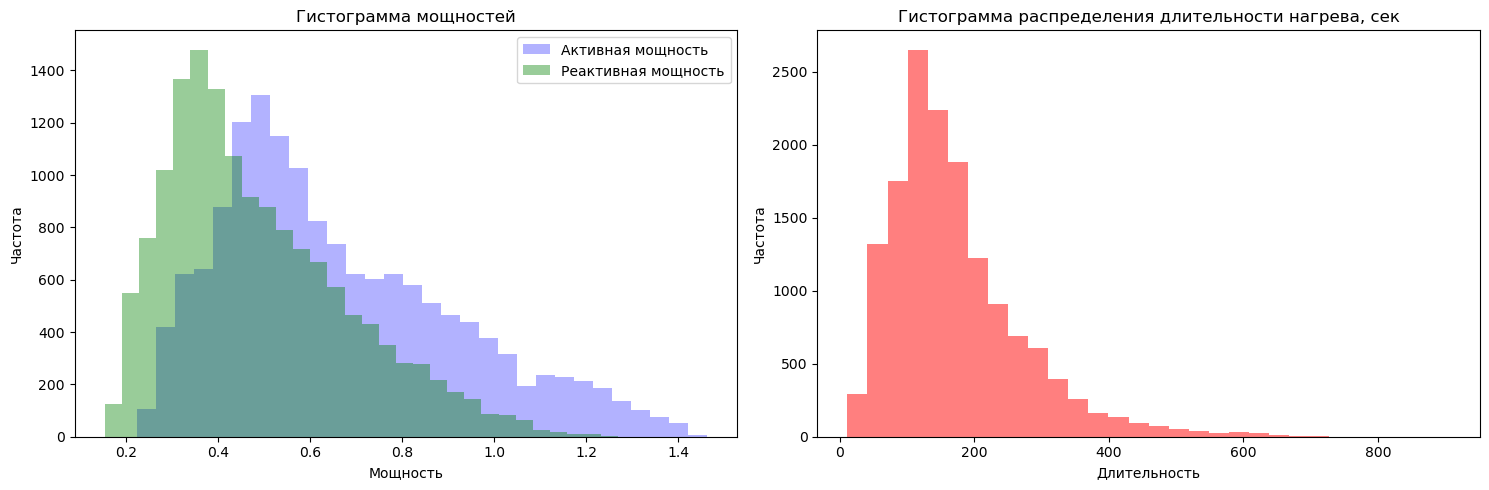

In [ ]:
# изучим данные визуально
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(data_arc.loc[data_arc['Реактивная мощность'] > 0,'Активная мощность'],
            bins=30, alpha=0.3, color='blue', label='Активная мощность')
axs[0].hist(data_arc.loc[data_arc['Реактивная мощность'] > 0,'Реактивная мощность'],
            bins=30, alpha=0.4, color='green', label='Реактивная мощность')
axs[0].set_title('Гистограмма мощностей')
axs[0].set_xlabel('Мощность')
axs[0].set_ylabel('Частота')
axs[0].legend()

axs[1].hist(data_arc.loc[data_arc['Реактивная мощность'] >0,'delta_time'], bins=30, alpha=0.5, color='red')
axs[1].set_title('Гистограмма распределения длительности нагрева, сек')
axs[1].set_xlabel('Длительность')
axs[1].set_ylabel('Частота')
plt.tight_layout()

plt.show()

___
**Data_arc**   
*Данные об электродах:* пропусков нет. Посчитал длительность нагрева. Есть пропущенные партии (`key`). Присутствуют аномалии в реактивной мощности (1 ячейка).

Данные распределены близко к нормальному со скосом вправо. Дубликатов нет.

---

### Data_bulk

In [ ]:
# изучим общую инфо
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
# посмотрим на пропуски
data_bulk.iloc[:, 1:].isna().all(axis=1).sum()

0

In [ ]:
# посмотрим на дубли
data_bulk.duplicated().sum()

0

In [ ]:
# посмотрим на описание данных
description = data_bulk.describe().round(2)
sorted_index = description.loc['count'].sort_values(ascending=False).index
sorted_description = description[sorted_index]
sorted_description

,key,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Bulk 1,Bulk 11,Bulk 10,Bulk 5,Bulk 7,Bulk 2,Bulk 9,Bulk 13,Bulk 8
count,3129.00,2806.00,2450.00,2248.00,1298.00,1014.00,576.00,252.00,177.00,176.00,77.00,25.00,22.00,19.00,18.00,1.0
mean,1624.38,170.28,260.47,160.51,113.88,104.39,118.93,39.24,76.82,83.28,107.03,305.60,253.05,76.32,181.11,49.0
std,933.34,65.87,120.65,51.77,75.48,48.18,72.06,18.28,59.66,26.06,81.79,191.02,21.18,21.72,46.09,NaN
min,1.00,16.00,53.00,1.00,6.00,12.00,17.00,10.00,8.00,24.00,11.00,47.00,228.00,63.00,151.00,49.0
25%,816.00,119.00,204.00,105.00,58.00,72.00,69.75,27.00,25.00,64.00,70.00,155.00,242.00,66.00,153.25,49.0
50%,1622.00,151.00,208.00,160.00,97.50,102.00,100.00,31.00,64.00,86.50,86.00,298.00,251.50,68.00,155.50,49.0
75%,2431.00,205.75,316.00,205.00,152.00,133.00,157.00,46.00,106.00,102.00,132.00,406.00,257.75,70.50,203.50,49.0
max,3241.00,636.00,1849.00,405.00,454.00,281.00,503.00,185.00,313.00,159.00,603.00,772.00,325.00,147.00,305.00,49.0


In [ ]:
# посмотрим саму таблицу
data_bulk.sample(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2144,2222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,NaN,NaN,NaN,NaN,NaN
2726,2829,NaN,NaN,NaN,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,414.0,NaN,200.0,106.0
1193,1242,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,125.0,204.0
1122,1170,NaN,NaN,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0,NaN
1720,1780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0,NaN,200.0,206.0
491,518,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,NaN,136.0,205.0
1698,1758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,352.0,203.0
1677,1737,NaN,NaN,NaN,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,119.0,204.0
48,57,27.0,NaN,NaN,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN,414.0,NaN,310.0,205.0
439,465,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,206.0,NaN,151.0,155.0


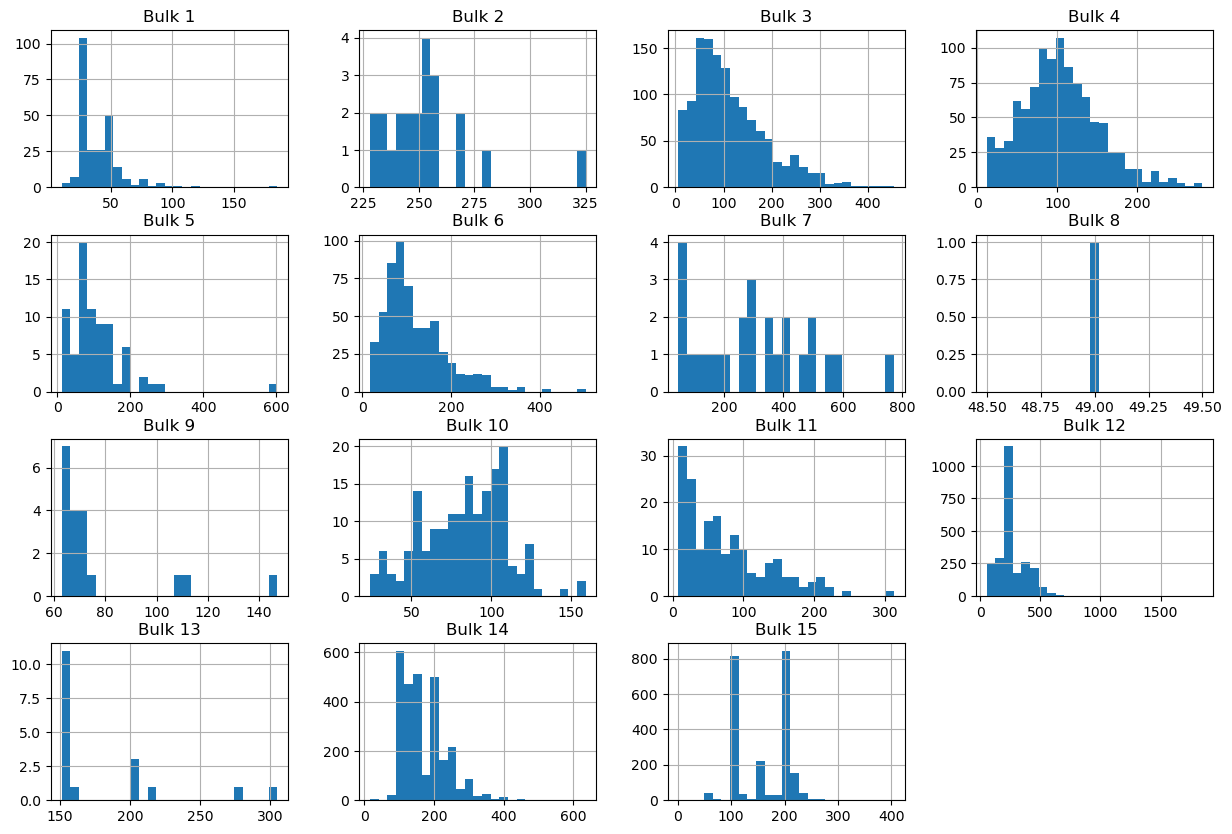

In [ ]:
# визуализируем данные
data_bulk.iloc[:,1:].hist(figsize=(15, 10), bins=25);

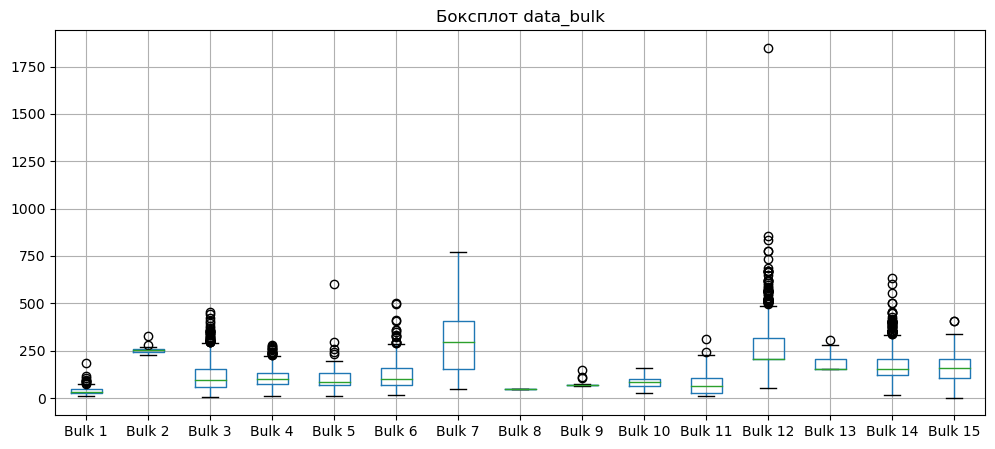

In [ ]:
# посмотрим аномалии
data_bulk.iloc[:,1:].boxplot(figsize=(12, 5))
#plt.ylim(0,1000)

plt.title('Боксплот data_bulk');

___
**Data_bulk**   
*Данные о подаче сыпучих материалов (объем)* - пропусков нет, дубликатов нет. В Bulk 12 и Bulk 5 наблюдается яркая аномалия, остальные значения являются экстремальными, но в рамках производственного процесса. Сыпучие материалы используются с разной частотой - часто Bulk 12, реже Bulk 8. В некоторых случаях данные распределены близко к нормальным (там, где достаточно наблюдений), обнаружены отдельные высокочастотные значения в части столбцов - скорее всего, это дефолтный объем.

В этой таблице меньше партий (`key`), чем в data_arc (3129 < 3214).

---

### Data_bulk_time

In [ ]:
# общее инфо
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
# приводим тип данных в порядок
for i in data_bulk_time.columns[1:]:
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i])
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56


In [ ]:
# сделаем датафрейм с порядком добавления примесей для каждой партии, это пригодится как категориальная фича для моделирования
order_bulk_time = data_bulk_time.iloc[:, 1:].T.rank(method='dense', na_option='keep', axis=0).T
order_bulk_time.insert(0, 'key', data_bulk_time['key'])

order_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,1.0
1,2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,2.0
2,3,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,1.0
3,4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,2.0
4,5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0
5,6,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,3.0
6,7,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,2.0
7,8,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,1.0
8,9,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,1.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,1.0


In [ ]:
# посмотрм его описание
order_bulk_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,2.797619,2.863636,2.516949,2.576923,2.727273,2.598958,1.400000,1.0,2.157895,2.687500,2.559322,2.622857,2.277778,1.961867,1.292705
std,933.337642,1.567446,1.521135,1.397246,1.345351,1.199083,1.332118,0.645497,NaN,1.067872,1.356071,1.214559,0.864792,0.574513,0.644439,0.505158
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,816.000000,1.000000,1.250000,1.000000,1.000000,2.000000,1.000000,1.000000,1.0,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,1622.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.000000,1.0,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,1.000000
75%,2431.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,1.0,3.000000,4.000000,4.000000,3.000000,3.000000,2.000000,2.000000
max,3241.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,3.000000,1.0,4.000000,5.000000,5.000000,5.000000,3.000000,4.000000,3.000000


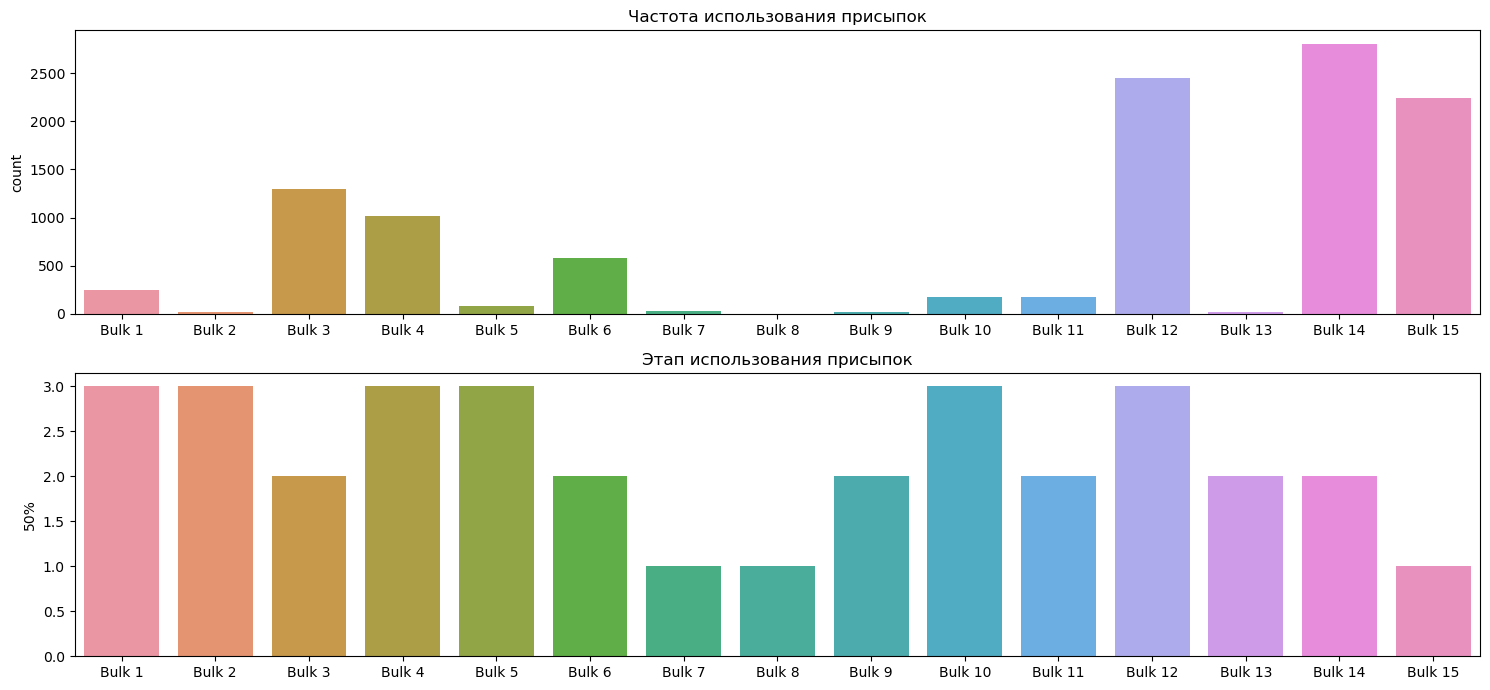

In [ ]:
# визуализируем данные
fig, axs = plt.subplots(2, 1, figsize=(15, 7))

sns.barplot(y=order_bulk_time.describe().loc['count','Bulk 1':],x=order_bulk_time.describe().columns[1:], ax=axs[0])
axs[0].set_title('Частота использования присыпок')

sns.barplot(y=order_bulk_time.describe().loc['50%','Bulk 1':],x=order_bulk_time.describe().columns[1:], ax=axs[1])
axs[1].set_title('Этап использования присыпок')

plt.tight_layout()

plt.show()

---

**data_bulk_time**   

*Данные о подаче сыпучих материалов (время)* - столбец, содержащий время по data_bulk. Наиболее часто добавляемые примеси поступают в основном на 1 - 3 этапе. Топ используемых присыпок: Bulk 12, Bulk 14, Bulk 15. В задаче эта информация не будет применяться.

---

### Data_gas

In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [ ]:
data_gas.duplicated().sum()

0

In [ ]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


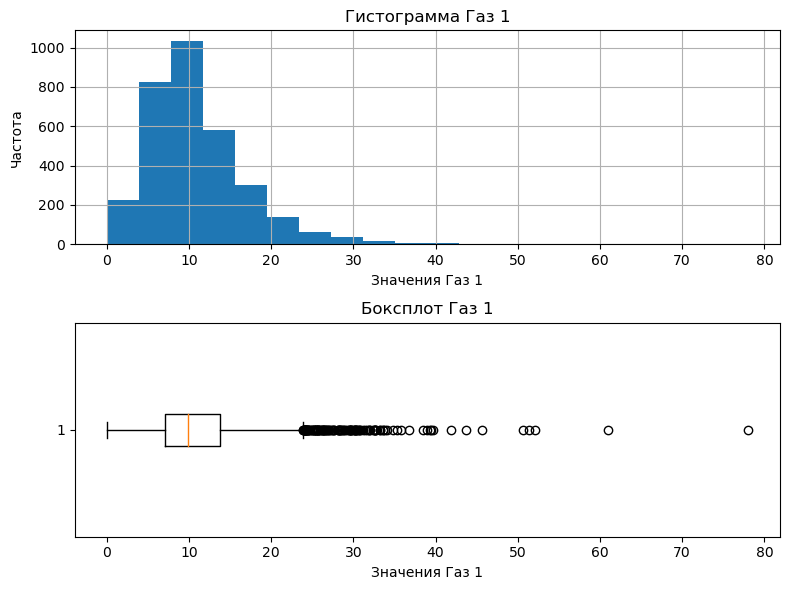

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
data_gas['Газ 1'].hist(bins=20)
plt.xlabel('Значения Газ 1')
plt.ylabel('Частота')
plt.title('Гистограмма Газ 1')

# Боксплот
plt.subplot(2, 1, 2)
plt.boxplot(data_gas['Газ 1'], vert=False)
plt.xlabel('Значения Газ 1')
plt.title('Боксплот Газ 1')

plt.tight_layout()
plt.show()

___
**Data_gas**   
*Данные о продувке сплава газом* - пропусков нет, дубликатов нет. Данные распределены близко к нормальному распределению. Присутствуют экстремальные значения.

Разное количество `key`

---

### Data_temp

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [ ]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [ ]:
data_temp.isna().mean()

key             0.000000
Время замера    0.000000
Температура     0.189421
dtype: float64

In [ ]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


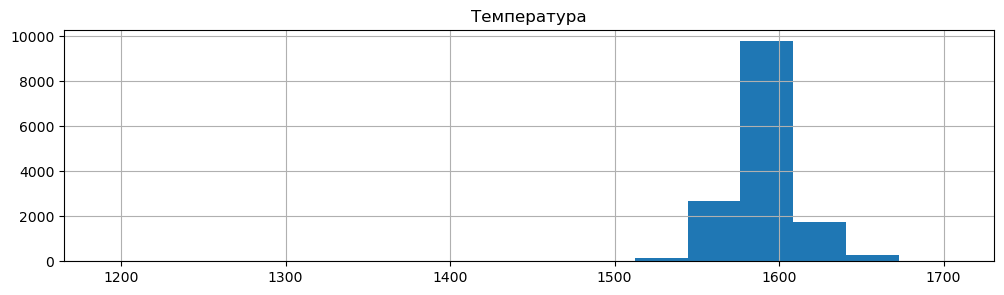

In [ ]:
data_temp.iloc[:, 2:].hist(figsize=(12, 3), bins=16);

In [ ]:
# проверим аномалии
print(data_temp['key'].nunique())
data_temp.loc[data_temp["Температура"] < 1500].count()[0]

3216


5

___
**Data_temp**   
*Результаты измерения температуры* - пропусков 20%, начиная с партии 2500, есть только первый замер. Эти партии необходимо удалить. Медианная температура составляет 1590 градусов, есть аномально низкие значения около 1200 градусов, их всего 5, которые будут удалены.

---

### Data_wire

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
# посмотрим на пропуски
data_wire.iloc[:, 1:].isna().all(axis=1).sum()

0

In [ ]:
# проверим на дубли
data_wire.duplicated().sum()

0

In [ ]:
# посмотрим на описание данных
description = data_wire.describe().round(2)
sorted_index_wire = description.loc['count'].sort_values(ascending=False).index
sorted_description_wire = description[sorted_index_wire]
sorted_description_wire

,key,Wire 1,Wire 2,Wire 6,Wire 3,Wire 9,Wire 8,Wire 4,Wire 7,Wire 5
count,3081.00,3055.00,1079.00,73.00,63.00,29.00,19.00,14.00,11.00,1.00
mean,1623.43,100.90,50.58,48.02,189.48,34.16,53.63,57.44,10.04,15.13
std,933.00,42.01,39.32,33.92,99.51,19.93,16.88,28.82,8.61,NaN
min,1.00,1.92,0.03,0.03,0.14,4.62,45.08,24.15,0.23,15.13
25%,823.00,72.12,20.19,25.05,95.14,22.06,46.09,40.81,6.76,15.13
50%,1619.00,100.16,40.14,42.08,235.19,30.07,46.28,45.23,9.02,15.13
75%,2434.00,126.06,70.23,64.21,276.25,43.86,48.09,76.12,11.89,15.13
max,3241.00,330.31,282.78,180.45,385.01,90.05,102.76,113.23,32.85,15.13


In [ ]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


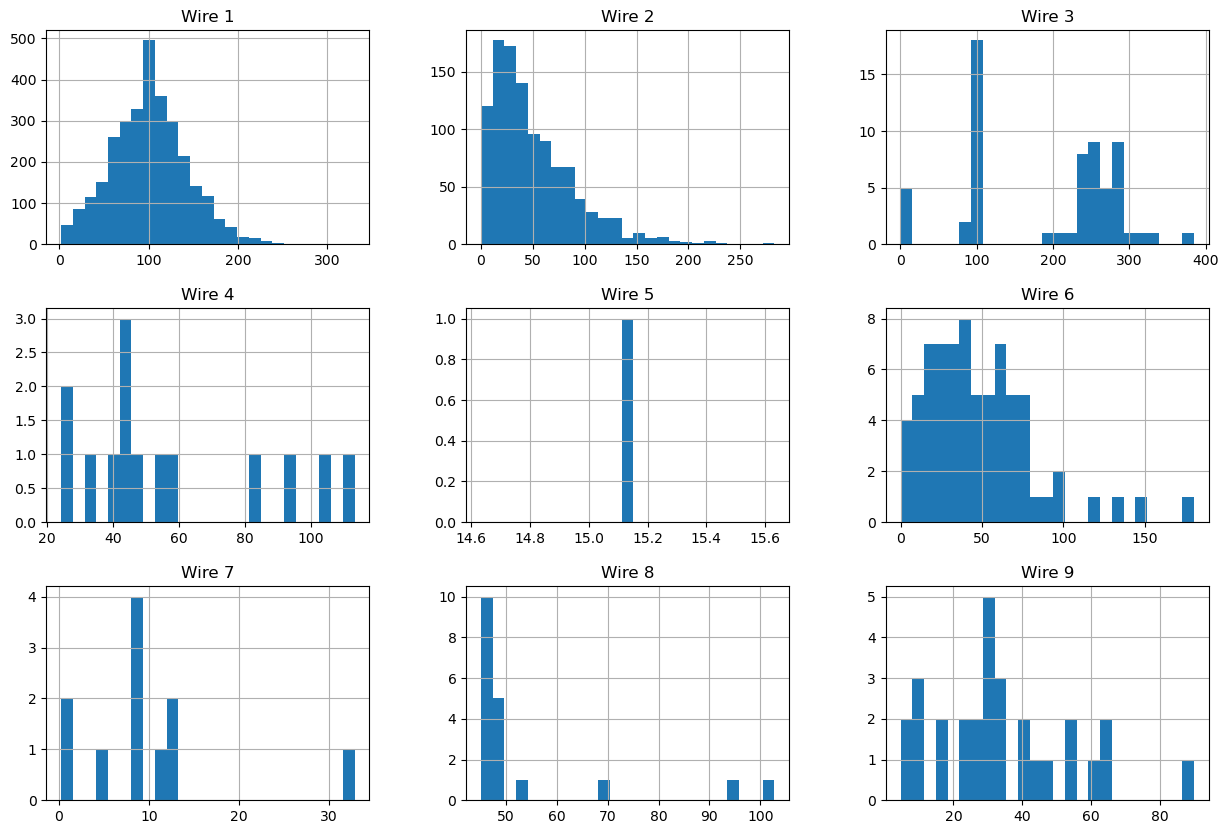

In [ ]:
# посмотрим на распределния
data_wire.iloc[:,1:].hist(figsize=(15, 10), bins=25);

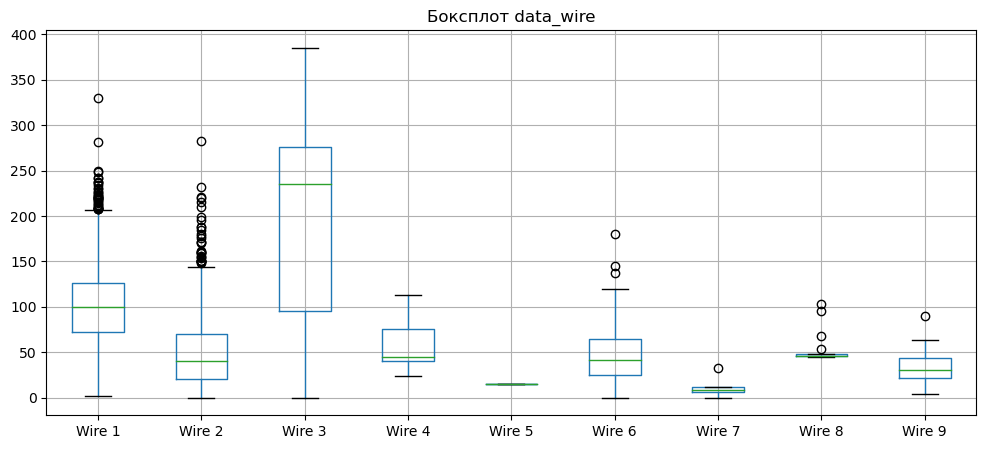

In [ ]:
data_wire.iloc[:,1:].boxplot(figsize=(12, 5))

plt.title('Боксплот data_wire');

___
**Data_wire**   
*Данные о проволочных материалах (объём)* - пропусков нет, дубликатов нет. Объёмы, добавляемые для разных проволок, отличаются. Есть часто используемые проволоки, распределение объёмов которых похоже на нормальное и логнормальное, а также проволоки, которые используются в особых случаях. Кроме того, можно заметить некоторые экстремальные значения. В гистограммах видны пики "дефолтных" значений.

---

### Data_wire_time

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [ ]:
for i in data_wire_time.columns[1:]:
    data_wire_time[i] = pd.to_datetime(data_wire_time[i])
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
# сделаем датафрейм с порядком добавления проволоки для каждой партии, это пригодится как категориальная фича для моделирования
order_wire_time = data_wire_time.iloc[:, 1:].T.rank(method='dense', na_option='keep', axis=0).T
order_wire_time.insert(0, 'key', data_bulk_time['key'])
order_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
order_wire_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.0,73.000000,11.0,19.0,29.0
mean,1599.579033,1.402946,1.072289,1.714286,2.285714,2.0,1.136986,1.0,1.0,1.0
std,919.005521,0.572502,0.259086,1.053850,0.726273,NaN,0.346212,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,2.0,1.000000,1.0,1.0,1.0
25%,804.000000,1.000000,1.000000,1.000000,2.000000,2.0,1.000000,1.0,1.0,1.0
50%,1598.000000,1.000000,1.000000,1.000000,2.000000,2.0,1.000000,1.0,1.0,1.0
75%,2394.000000,2.000000,1.000000,2.500000,3.000000,2.0,1.000000,1.0,1.0,1.0
max,3190.000000,5.000000,2.000000,4.000000,3.000000,2.0,2.000000,1.0,1.0,1.0


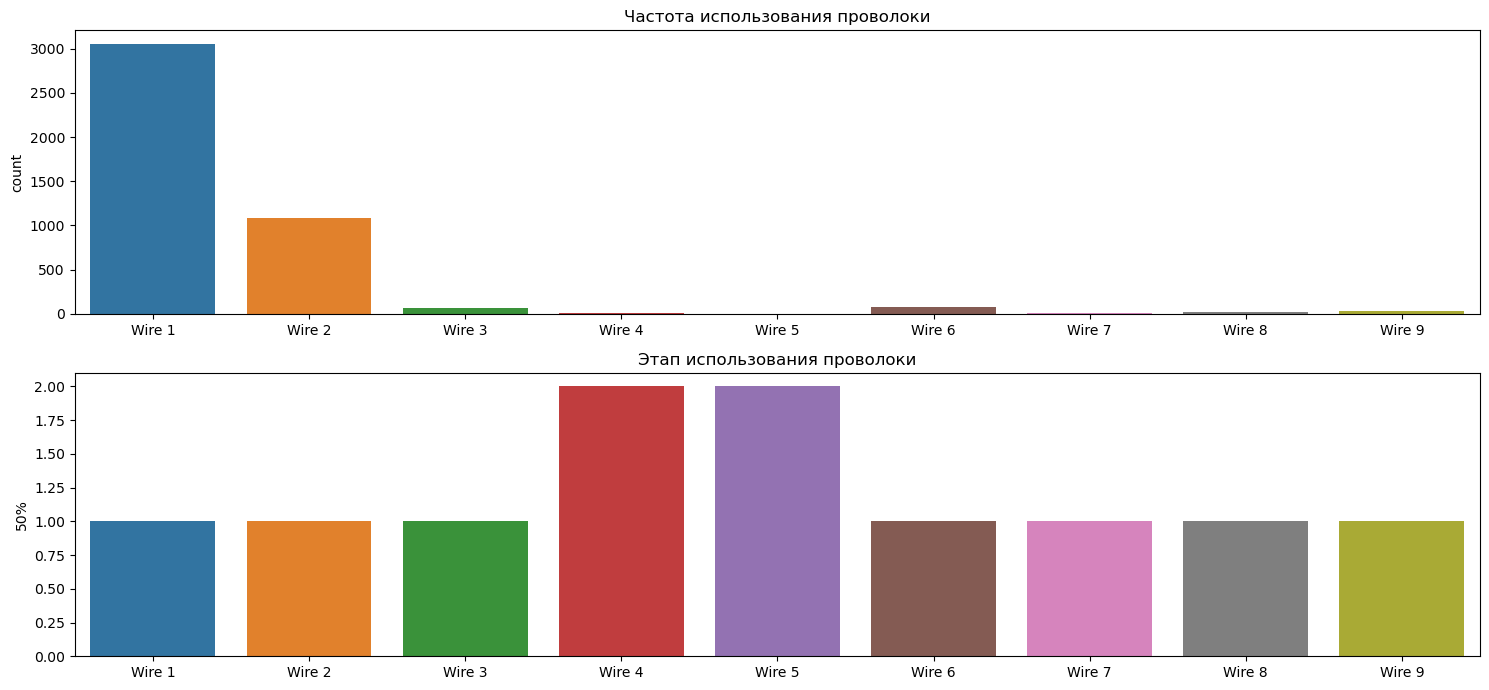

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7))

sns.barplot(y=order_wire_time.describe().loc['count','Wire 1':],x=order_wire_time.describe().columns[1:], ax=axs[0])
axs[0].set_title('Частота использования проволоки')

sns.barplot(y=order_wire_time.describe().loc['50%','Wire 1':],x=order_wire_time.describe().columns[1:], ax=axs[1])
axs[1].set_title('Этап использования проволоки')

plt.tight_layout()

plt.show()

___
**Data_wire_time**   
*Данные о проволочных материалах (дата)* - аналогичная предыдущей таблице, но с указанием дат. Наиболее часто добавляемая проволока - Wire 1, на втором месте - Wire 2. В основном их добавляют на первом этапе, реже - Wire 4 и Wire 5 на втором.

---

In [ ]:
tables = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

merged_df = pd.merge(tables[0], tables[1], on='key', how='inner')

for i in range(2, len(tables)):
    merged_df = pd.merge(merged_df, tables[i], on='key', how='inner')
num_keys_before = merged_df['key'].nunique()
print("Количество уникальных key, которые есть во всех таблицах", num_keys_before)

Количество уникальных key, которые есть во всех таблицах 3022


**Вывод:**  

Нам дано 7 таблиц, в которых содержится различное количество значений для общего столбца `key`, обозначающего литейную партию. Всего "общих" партий во всех таблицах у нас 3022.

В данных присутствуют как экстремальные значения, так и аномалии, которые можно удалить в составе целой партии.

В целевой таблице "data_temp" последние 20% данных имеют пропуски, поэтому данные партии тоже будут стерты. Самый первый замер необходимо "извлечь" из таблицы как признак, от которой мы отталкиваемся. Последний замер - наш таргет.

Также, исходя из процесса, мы видим, что на каждые X нагревов соответствуют X+1 замер температуры.

## Предобработка данных

### Data_arc

In [ ]:
'''
Удалим партию с аномальной реактивной мощностью.

Сгенерируем новые функции:
- power_factor - отношение активной к полной мощности
- energy_spent - активная мощность на время работы.
'''

arc_erase_key = data_arc.loc[data_arc['Реактивная мощность'] < 0]['key'].values
data_arc = data_arc[~data_arc['key'].isin(arc_erase_key)]
data_arc['power_factor'] = data_arc['Активная мощность'] / (data_arc['Активная мощность']**2
                                                            + data_arc['Реактивная мощность']**2)**0.5
data_arc['energy_spent'] = data_arc['Активная мощность'] * data_arc['delta_time']

data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,delta_time,power_factor,energy_spent
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.822181,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.848545,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.803161,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.806591,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,0.802950,128.335684


In [ ]:
'''
Сагрегируем данные и найдем взвешенную среднюю активную мощность.
'''
agg_data_arc = data_arc.groupby(by='key').agg(key_time_sum=('delta_time', 'sum'),
                                                 power_factor=('power_factor', 'mean'),
                                                 energy_sum=('energy_spent', 'sum'))
agg_data_arc.reset_index(inplace=True)
agg_data_arc['active_power'] = agg_data_arc['energy_sum'] / agg_data_arc['key_time_sum']
agg_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3213 non-null   int64  
 1   key_time_sum  3213 non-null   float64
 2   power_factor  3213 non-null   float64
 3   energy_sum    3213 non-null   float64
 4   active_power  3213 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 125.6 KB


In [ ]:
agg_data_arc.head(5)

,key,key_time_sum,power_factor,energy_sum,active_power
0,1,1098.0,0.816686,628.616930,0.572511
1,2,811.0,0.825276,395.281800,0.487400
2,3,655.0,0.809724,581.774624,0.888206
3,4,741.0,0.793923,543.710274,0.733752
4,5,869.0,0.796818,412.180480,0.474316


---
**Агрегировал данные по электродам, удалил партию с аномалией, сгенерировал полезные фичи.**

---


### Data_bulk и data_bulk_time

In [ ]:
'''
заполним пропуски нулями
'''
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


---
**Заполнил пропуски.**

---

### Data_temp

Удалим партии с аномально низкими температурами и пропускам.

Сгенерируем новые фичи:
- `temp` - первое измерение температуры.
- `duration` - время всей партии.

Извлечем таргет - последнее измерение.

In [ ]:
# количество партий до предобработки
count_key_before = data_temp['key'].nunique()

# партии с аномалией
temp_erase_key = data_temp.loc[data_temp['Температура'] < 1400]['key'].values

# теперь партии с пропусками уберем
temp_erase_key2 = data_temp.loc[data_temp['Температура'].isna()]['key'].unique()

# партии с одним измерением
temp_erase_key3 = data_temp['key'].value_counts().loc[lambda x: x == 1].index

# склеим их
temp_erase = np.hstack((temp_erase_key2, temp_erase_key, temp_erase_key3))

In [ ]:
# сагрегируем сначала фичи
agg_data_temp = data_temp.groupby(by='key').agg(start_temp=('Температура', 'first'),
                                                 start_time=('Время замера', 'first'),
                                                 end_time=('Время замера', 'last'))
# сбросим индексы
agg_data_temp.reset_index(inplace=True)

# теперь удалим строки  с пропусками и аномалиями
agg_data_temp = agg_data_temp[~agg_data_temp['key'].isin(temp_erase)]

# вычисляем нужные фичи
agg_data_temp['duration'] = (agg_data_temp['end_time'] - agg_data_temp['start_time']).dt.total_seconds()

# удалим промежуточные фичи
agg_data_temp = agg_data_temp.drop(columns=['start_time', 'end_time'])

# заполним пропуск для первой плавки
agg_data_temp = agg_data_temp.fillna(0)
agg_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2471 non-null   int64  
 1   start_temp  2471 non-null   float64
 2   duration    2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


In [ ]:
count_key_after = agg_data_temp['key'].nunique()
print("До предобработки:", count_key_before)
print("После предобработки:", count_key_after)
print("Сколько партий удалили", count_key_before - count_key_after)
print("Их доля, в %", round(((count_key_before - count_key_after) * 100 / count_key_before), 2))

До предобработки: 3216
После предобработки: 2471
Сколько партий удалили 745
Их доля, в % 23.17


In [ ]:
agg_data_temp.head(5)

,key,start_temp,duration
0,1,1571.0,1714.0
1,2,1581.0,1265.0
2,3,1596.0,1753.0
3,4,1601.0,1220.0
4,5,1576.0,1536.0


In [ ]:
# извлечем таргет - последнее измерение температуры
target = data_temp.groupby(by='key').agg(target_temp=('Температура', 'last')).reset_index()
target.head(5)

,key,target_temp
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


---
**Удалили партии с аномалиями.  
Удалили партии с пропусками.  
Сгенерировали новые фичи.  
Выделили таргет**

---

### Data_wire и data_wire_time

Заполним пропуски. Ярких аномалий в этих таблицах нет.

In [ ]:
data_wire = data_wire.fillna(0)

order_wire_time = order_wire_time.fillna(0)

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
order_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
order_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
**Заполнили пропуски**

---

### Подготовка данных к моделированию

- Соберем единый датафрейм
- Исследуем собранные признаки

In [ ]:
tables = [target, agg_data_temp, agg_data_arc, data_bulk, data_gas, data_wire]

fin_table = pd.merge(tables[0], tables[1], on='key', how='inner')

for i in range(2, len(tables)):
    fin_table = pd.merge(fin_table, tables[i], on='key', how='inner')

fin_table = fin_table.set_index('key')

In [ ]:
print("Количество партий до обработки после объединения", num_keys_before)
print("Количество партий после обработки после объединения", len(fin_table))
print(f'Разница в кол-ве: - {num_keys_before - len(fin_table)}  \
в процентах - {(num_keys_before - len(fin_table))/ num_keys_before:%}')

Количество партий до обработки после объединения 3022
Количество партий после обработки после объединения 2324
Разница в кол-ве: - 698  в процентах - 23.097287%


In [ ]:
fin_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target_temp   2324 non-null   float64
 1   start_temp    2324 non-null   float64
 2   duration      2324 non-null   float64
 3   key_time_sum  2324 non-null   float64
 4   power_factor  2324 non-null   float64
 5   energy_sum    2324 non-null   float64
 6   active_power  2324 non-null   float64
 7   Bulk 1        2324 non-null   float64
 8   Bulk 2        2324 non-null   float64
 9   Bulk 3        2324 non-null   float64
 10  Bulk 4        2324 non-null   float64
 11  Bulk 5        2324 non-null   float64
 12  Bulk 6        2324 non-null   float64
 13  Bulk 7        2324 non-null   float64
 14  Bulk 8        2324 non-null   float64
 15  Bulk 9        2324 non-null   float64
 16  Bulk 10       2324 non-null   float64
 17  Bulk 11       2324 non-null   float64
 18  Bulk 12       2324 non-null 

In [ ]:
fin_table.describe()

,target_temp,start_temp,duration,key_time_sum,power_factor,energy_sum,active_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000
mean,1593.372633,1587.368761,2323.682014,808.196644,0.805477,539.381127,0.665070,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313,11.378854,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795
std,11.207457,23.627590,1385.809791,340.813828,0.013955,257.301093,0.139447,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967,6.397008,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248
min,1541.000000,1519.000000,339.000000,57.000000,0.739789,26.187544,0.267676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1587.000000,1571.000000,1580.500000,581.000000,0.796794,368.304687,0.562407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282534,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1593.000000,1587.000000,2046.500000,778.000000,0.806013,508.538758,0.653650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100687,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1598.000000,1603.000000,2793.500000,993.000000,0.814802,679.198659,0.751091,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.218487,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,1653.000000,1660.000000,23674.000000,4189.000000,0.857042,3718.054401,1.259114,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


Есть очень длинные плавки. Можно удалить признак Wire 5, который пустой.

In [ ]:
fin_table = fin_table.drop(columns = 'Wire 5')

Посмотрим матрицу корреляции признаков, чтобы избежать мультиколлинеарности для линейных моделей.

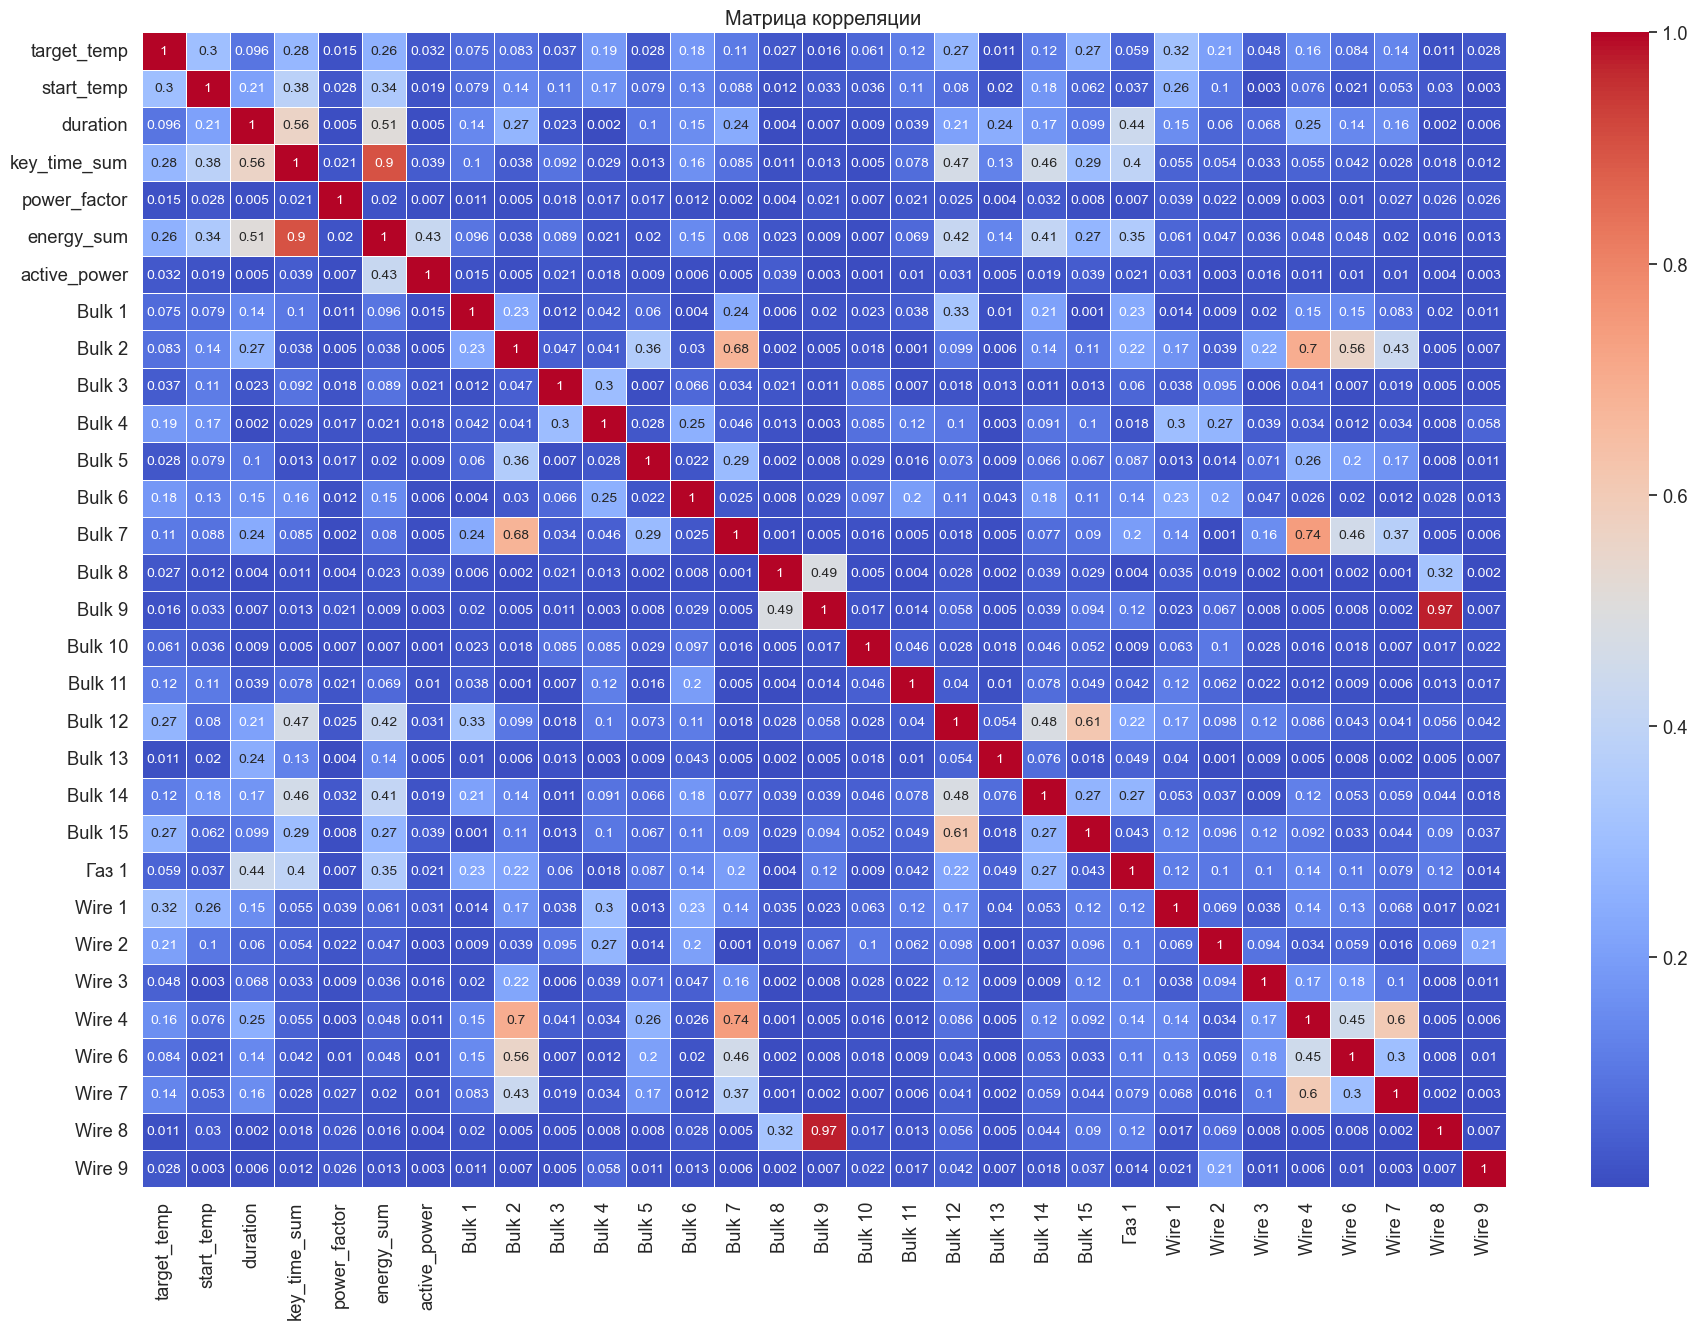

In [ ]:
plt.figure(figsize=(22, 15))

sns.set(font_scale=1.2)
sns.set_style("whitegrid")

sns.heatmap(abs(fin_table.corr().round(3)), annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"size": 10})
plt.title("Матрица корреляции")
plt.show()

Есть несколько признаков, которые сильно коррелируют друг с другом (Wire 8 и Bulk 9), (key_time_sum и energy_sum), удалим из  этих пар по одному признаку.  

С целевой переменной сильно коррелируемых фич нет.

In [ ]:
fin_table = fin_table.drop(columns = ['Wire 8', 'key_time_sum'])

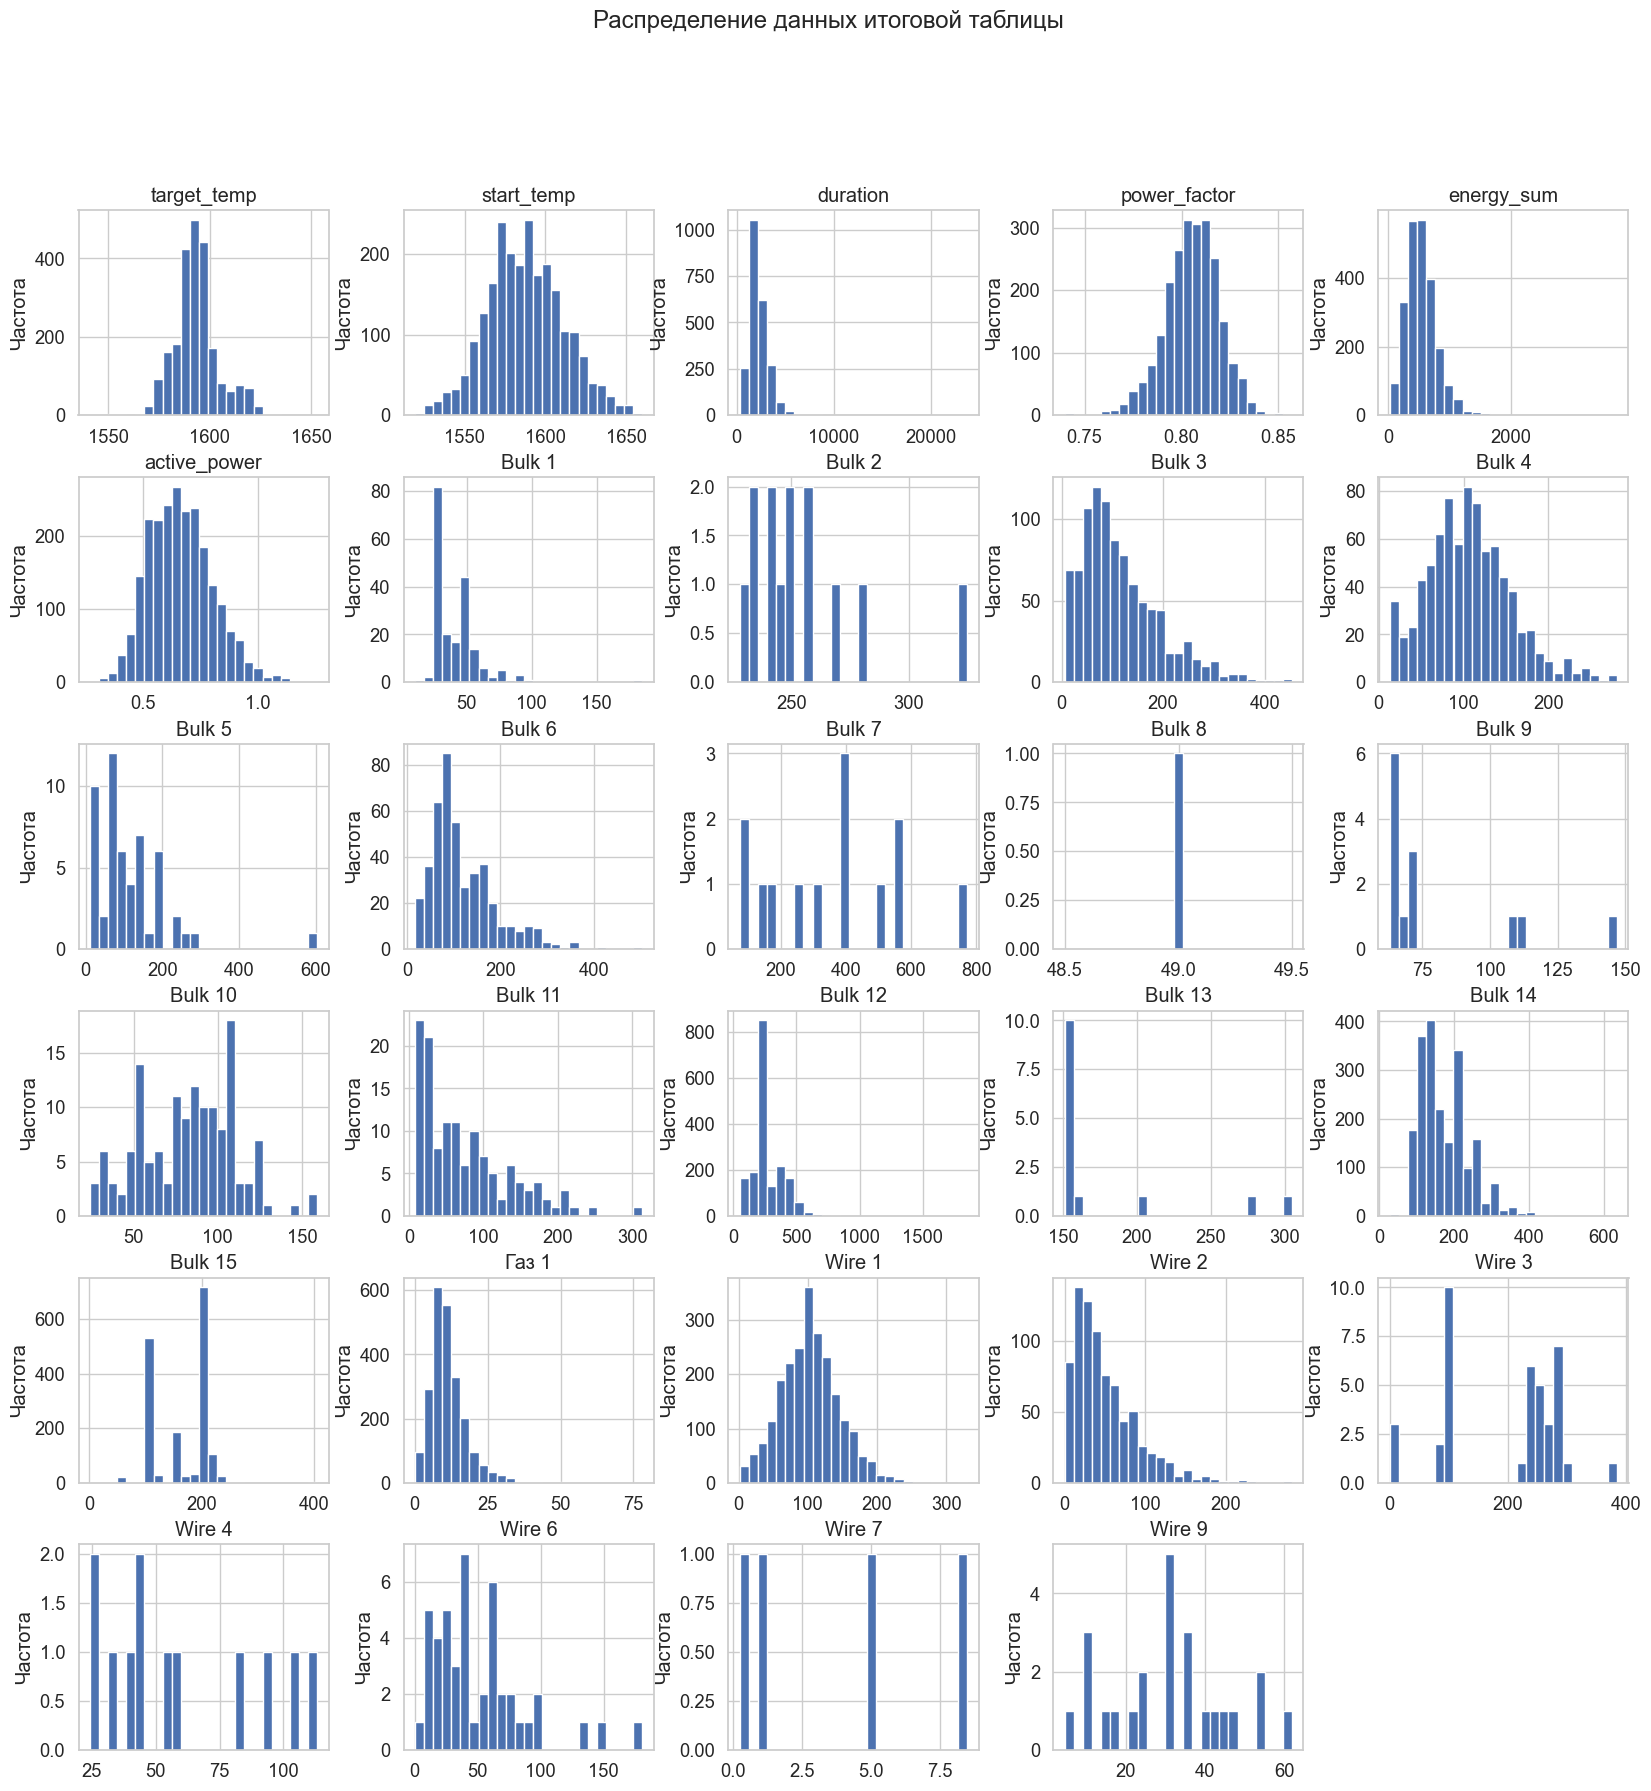

In [ ]:
fin_table[fin_table != 0].hist(bins=25, figsize=(20, 20))

plt.suptitle('Распределение данных итоговой таблицы')

for ax in plt.gcf().get_axes():
    ax.set_ylabel('Частота')

plt.show()

Распределения выглядят хорошо, есть аномальные значения, но они объясняются производственными процессами.

In [ ]:
# визуализируем наши многомерные данные с использованием PCA
col = fin_table.columns[1:]

x = fin_table.loc[:, col].values
y = fin_table.iloc[:, 0].values

# стандартизируем сначала
x = StandardScaler().fit_transform(x)

# теперь применим PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)

principal_df = pd.DataFrame(data = principal_components
             , columns = ['pc1', 'pc2', 'pc3'])

In [ ]:
pca.explained_variance_ratio_

array([0.13215405, 0.10078002, 0.07625353])

PCA слабо помог описать наши данные, попробуем оценить графически.

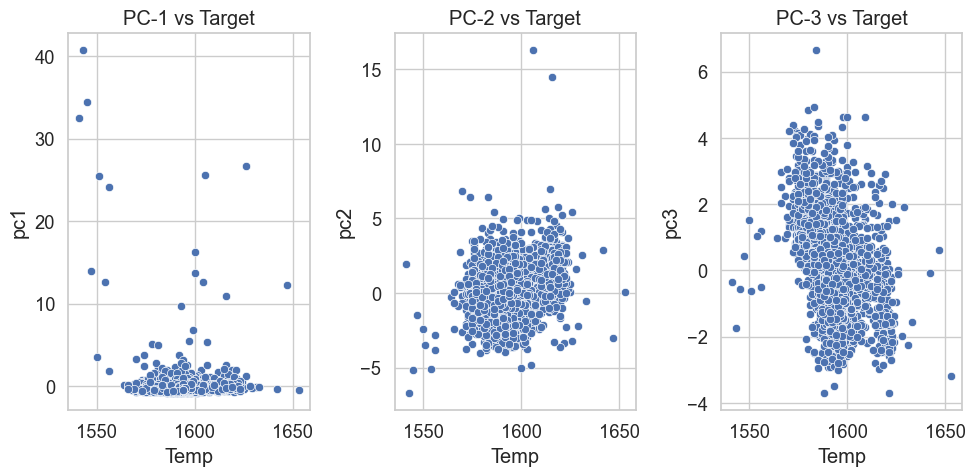

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

sns.scatterplot(y=principal_df['pc1'] ,x=y, ax=axs[0])
axs[0].set_title('PC-1 vs Target')
axs[0].set_xlabel('Temp')

sns.scatterplot(y=principal_df['pc2'] ,x=y, ax=axs[1])
axs[1].set_title('PC-2 vs Target')
axs[1].set_xlabel('Temp')

sns.scatterplot(y=principal_df['pc3'], x=y, ax=axs[2])
axs[2].set_title('PC-3 vs Target')
axs[2].set_xlabel('Temp')

plt.tight_layout()

plt.show()

Снижение размерности не помогло обнаружить ярких закономерностей с температурой, однако PC-3 выглядит неплохо, посмотрим какие признаки там главенствуют.

In [ ]:
pd.DataFrame(data = abs(pca.components_)
             , columns = col).T.sort_values(by=[2, 1, 0], ascending=False)

,0,1,2
Bulk 4,0.023692,0.002494,0.449880
Bulk 6,0.007239,0.088895,0.412490
Wire 1,0.066735,0.108045,0.364138
Wire 2,0.005369,0.022528,0.352361
start_temp,0.077472,0.126100,0.317787
Bulk 11,0.000413,0.038068,0.250537
Bulk 15,0.057116,0.331445,0.216556
Bulk 3,0.018386,0.059215,0.213527
Bulk 12,0.012931,0.457384,0.207419
energy_sum,0.091204,0.465338,0.114067


Bulk 4, Bulk 6, Wire 1, Wire 2, start_temp - признаки с наивысшей корреляцией, также графически отражают непосредственное влияние на таргет.

---
**Собрали все данные в одну таблицу. Проанализировали итоговую таблицу. Удалили коллинеарные признаки. Данные готовы к разделению на выборки и дальнейшему моделированию. В результате обработки невалидными оказались 25% процентов партий.**

---

## Моделирование

In [ ]:
features = fin_table.drop(['target_temp'], axis=1)
target = fin_table['target_temp']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=SEED)

### Простая модель - Ridge

In [ ]:
pipeline_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', Ridge())
    ])

mae_ridge_cv = cross_val_score(pipeline_ridge, features_train, target_train, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
print('MAE TRAIN по CV - RIDGE', round(-sum(mae_ridge_cv)/len(mae_ridge_cv), 3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


MAE TRAIN по CV - RIDGE 6.354


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished



---
**Ridge без настроек выдает отнюдь неплохой результат MAE  - 6.354**

---

### ElasticNet

In [ ]:
steps = ([
    ('scale', StandardScaler()),
    ('regressor', LinearRegression(n_jobs=-1))
    ])

In [ ]:
params = [{'regressor': [ElasticNet()],
                  'regressor__alpha': [0.01, 0.1, 0.5, 1.0],
                  'regressor__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
                  'regressor__l1_ratio': [.0, 0.1, 0.25, 0.5, 0.75, 1.0]
          }]

In [ ]:
def pipeline_RSCV(X, y, steps, params, verbose=1):

    pipe = Pipeline(steps)

    # собираем все вместе, запускаем поиск
    grid = RandomizedSearchCV(pipe, params, n_iter=100, n_jobs=-1, cv=5,
                             scoring='neg_mean_absolute_error', verbose=1, random_state=SEED)
    grid.fit(X, y)

    #Посмотрим наилучшие подобранные параметры
    print()
    print('Параметры лучшей модели:', grid.best_params_)
    print()
    print('Значение лучшей метрики качества:', -grid.best_score_)
    print()

    return grid

In [ ]:
%%time
linear_models = pipeline_RSCV(features_train, target_train, steps, params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Параметры лучшей модели: {'regressor__tol': 1e-05, 'regressor__l1_ratio': 1.0, 'regressor__alpha': 0.1, 'regressor': ElasticNet(alpha=0.1, l1_ratio=1.0, tol=1e-05)}

Значение лучшей метрики качества: 6.327759515041241

CPU times: total: 953 ms
Wall time: 3.53 s


In [ ]:
(pd.DataFrame(linear_models.cv_results_)
  [['params', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
  .sort_values(by='mean_test_score', ascending=False)
  .head())

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
50,"{'regressor__tol': 1e-05, 'regressor__l1_ratio...",-6.327760,1,0.015185,0.006467
40,"{'regressor__tol': 0.01, 'regressor__l1_ratio'...",-6.330892,2,0.020526,0.008207
36,"{'regressor__tol': 0.1, 'regressor__l1_ratio':...",-6.347955,3,0.021586,0.009420
67,"{'regressor__tol': 0.01, 'regressor__l1_ratio'...",-6.350539,4,0.015562,0.001599
15,"{'regressor__tol': 0.001, 'regressor__l1_ratio...",-6.350570,5,0.022413,0.010100



---
**ElasticNet с подбором гиперпараметров дает по СV MAE - 6.328**

---

### LightGBM

In [ ]:
steps = [
#    ('scale', StandardScaler()),
    ('regressor', lgb.LGBMRegressor())
]

In [ ]:
param_grid = {
    'regressor__learning_rate': np.arange(0.001, 0.07, 0.01),
    'regressor__n_estimators': np.arange(600, 710, 10),
    'regressor__num_leaves': np.arange(48, 54, 1),
    'regressor__max_depth': np.arange(3, 5, 1),
    'regressor__min_child_samples': [10, 30],
    'regressor__subsample': [0.7, 0.8],
    'regressor__colsample_bytree': [0.7, 0.8],
}

lgbm_model = RandomizedSearchCV(estimator=Pipeline(steps),
                            param_distributions=param_grid,
                            n_iter=10,
                            n_jobs=-1,
                            cv=5,
                            scoring='neg_mean_absolute_error',
                            verbose=1,
                            error_score='raise',
                            random_state=SEED)

In [ ]:
%%time
lgbm_model.fit(features_train, target_train)

print()
print("Лучшие параметры:", lgbm_model.best_params_)
print()
print('Значение лучшей метрики качества:', -lgbm_model.best_score_)
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Лучшие параметры: {'regressor__subsample': 0.7, 'regressor__num_leaves': 51, 'regressor__n_estimators': 700, 'regressor__min_child_samples': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.040999999999999995, 'regressor__colsample_bytree': 0.8}

Значение лучшей метрики качества: 5.788608671659192

CPU times: total: 1.17 s
Wall time: 6.17 s


In [ ]:
(pd.DataFrame(lgbm_model.cv_results_)
  [['params', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
  .sort_values(by='mean_test_score', ascending=False)).head(10)

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
1,"{'regressor__subsample': 0.7, 'regressor__num_...",-5.788609,1,0.462478,0.026655
6,"{'regressor__subsample': 0.8, 'regressor__num_...",-5.864363,2,0.394341,0.031243
9,"{'regressor__subsample': 0.8, 'regressor__num_...",-5.892072,3,0.502563,0.022962
3,"{'regressor__subsample': 0.7, 'regressor__num_...",-5.954566,4,0.510629,0.031345
2,"{'regressor__subsample': 0.7, 'regressor__num_...",-5.971983,5,0.415964,0.027568
7,"{'regressor__subsample': 0.7, 'regressor__num_...",-5.986126,6,0.475220,0.021869
4,"{'regressor__subsample': 0.8, 'regressor__num_...",-5.992920,7,0.626214,0.027662
0,"{'regressor__subsample': 0.7, 'regressor__num_...",-6.004051,8,0.501973,0.024975
8,"{'regressor__subsample': 0.7, 'regressor__num_...",-7.181586,9,0.584237,0.024995
5,"{'regressor__subsample': 0.8, 'regressor__num_...",-7.314774,10,0.450656,0.020751


---
**LGBM_Regressor с подбором гиперпараметров дает по СV MAE - 5.788**

---

**ВЫВОД**  

Ridge без настроек - MAE  - 6.354  
ElasticNet с подбором гиперпараметров  MAE - 6.328  
LGBM_Regressor с подбором гиперпараметров  MAE - 5.788  

**Берем в тест LGBM_Regressor, который показывает отличный результат**



### Тестирование и проверка

In [ ]:
print('MAE TEST LGBM с подбором ГП:  ', round(mean_absolute_error(target_test, lgbm_model.predict(features_test)), 3))

MAE TEST LGBM с подбором ГП:   6.328


---
**LGBM_Regressor на тестовой выборке МАЕ - 6.328**  

---

In [ ]:
# сравним результат с глупой моделью
dummy_model = DummyRegressor(strategy="mean")

dummy_model_cv = cross_val_score(dummy_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

dummy_model.fit(features_train, target_train)

print('MAE DUMMY TRAIN по CV ', round(-sum(dummy_model_cv)/len(dummy_model_cv), 3))
print()
print('MAE DUMMY TEST' , round(mean_absolute_error(target_test, dummy_model.predict(features_test)), 3))

MAE DUMMY TRAIN по CV  7.882

MAE DUMMY TEST 8.684


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


---
**DUMMY МАЕ TRAIN - 7.882  
DUMMY MAE TEST - 8.684**  

**Выбранная модель - работает лучше чем константная, значит обучение получилось**


---

### Исследуем важность признаков

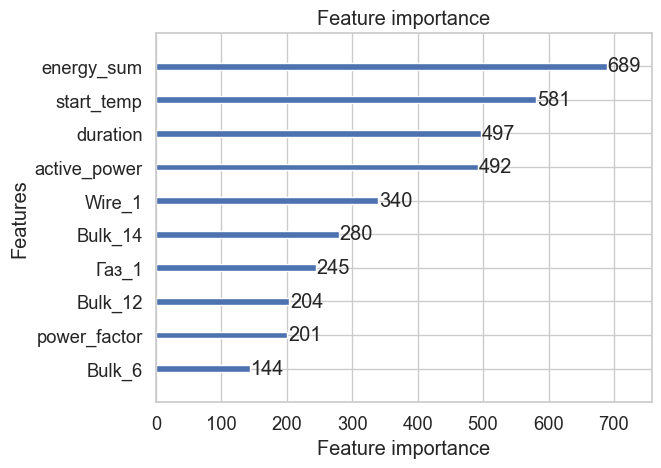

In [ ]:
lgb.plot_importance(lgbm_model.best_estimator_.named_steps['regressor'].booster_, max_num_features=10, importance_type='split')
plt.show()

**Самыми важными признаками оказались "energy_sum", "start_temp", "active_power" и "duration", что соответствует производственному процессу - сколько мы потратили энергии при стартовой температуре и за время Х секунд.**

Проверим еще по  SHAP.  

График Summary Plot SHAP (SHapley Additive exPlanations) предоставляет обобщенное представление о важности признаков для всех предсказаний в наборе данных. Этот график помогает понять, какие признаки оказывают наибольшее влияние на предсказания модели и как они взаимодействуют.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


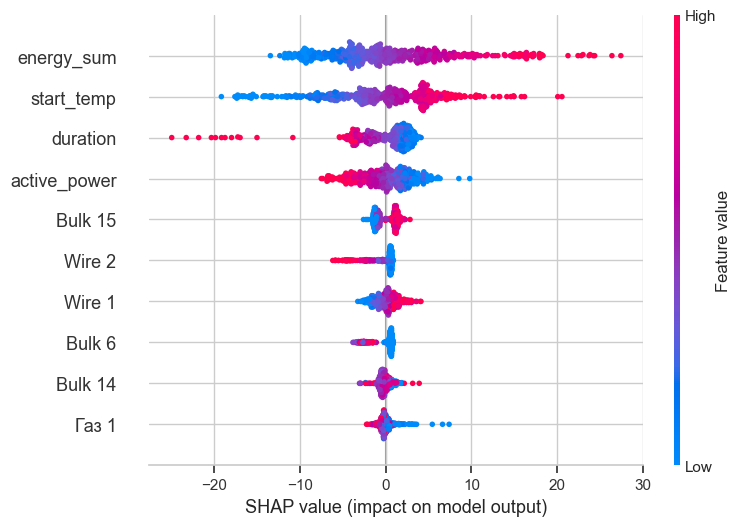

In [ ]:
explainer = shap.Explainer(lgbm_model.best_estimator_.named_steps['regressor'])

shap_values = explainer(features_test)

shap.summary_plot(shap_values, features_test, max_display=10)

SHAP Plot дублирует информацию о LGBM и подтверждает наш топ-10 признаков. Можно заметить, что любые наши выбросы в "импактных" признаках негативно влияют на качество предсказаний.

---
**Признаки отвечающие за нагрев и начальную температуру имеют наибольшую важность**

---

### Вывод

В ходе данного проекта были проведены успешные этапы предобработки данных и построения прогностической модели для прогнозирования температуры стали в производственном процессе.

Первоначально данные были подвергнуты обширной предобработке, включая удаление аномалий, заполнение пропусков и создание новых признаков. Затем была рассмотрена несколько моделей, включая Ridge, ElasticNet и LGBMRegressor. В результате сравнительного анализа, LGBMRegressor продемонстрировала наилучшую производительность, достигнув метрики MAE на уровне `5.788` на тренировочном наборе с CV и  `6.328` на тестовых данных.

Исследование важности признаков позволило выделить ключевые факторы, влияющие на прогноз температуры стали. Наибольшее влияние оказали параметры энергопотребления, начальной температуры и активной мощности, что согласуется с характеристиками производственного процесса.

## ОТЧЕТ
Цель проекта была достигнута. В ходе выполнения проекта был построен прогностический инструмент для предсказания температуры стали в процессе обработки, с целью оптимизации производственных расходов.

### Описание трудностей проекта

Анализирование и обработка разнообразных источников данных, включая отсутствие значений, аномалии и неоднородность в данных.  
Большое количество экстремальных значений ухудшает прогноз.
В результати обработки данных было отброшено почти 1/4 всех партий.
Также, определение наиболее важных признаков и их влияние на результат представляло собой некоторую сложность.

### Ключевые шаги решения

1. Проведение исследовательского анализа данных для понимания характера производственного процесса и выявления особенностей данных.
2. Подготовка данных: обработка пропусков, агрегация, создание новых признаков.
3. Моделирование: использование нескольких алгоритмов (Ridge, ElasticNet, LGBMRegressor) с подбором гиперпараметров.
4. Тестирование и выбор наилучшей модели, а также оценка важности признаков

### Признаки, использованные для обучения и их обработка

Для обучения модели были использованы и обработаны следующие таблицы:  
- data_arc_new — данные об электродах - *удалили партию с отрицательной мощностью*
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём) - *пропуски заполнили*
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры - *удалили аномалии с температурой ниже 1400, с пропусками в замерах, с единичным замером*
- data_wire_new.csv — данные о проволочных материалах (объём)  - *пропуски заполнили*

Модель была обучена на следующем наборе признаков сформированных из обработанных данных:

- **start_temp** - первая отметка `['Температура']` из таблица data_temp для каждой плавки


- **duration** -  Продолжительность плавки из таблицы data_temp `['Время замера', 'last']` - `['Время замера', 'first']` - время последнего измерения - время первого измерения


- **power_factor** - Коэффициент мощности - из таблицы data_arc `["Активная мощность"] / sqrt(["Активная мощность"]^2 + ["Реактивная мощность"]^2)` агрегировалось среднее для каждой плавки


- **energy_sum** - Сумма энергии - data_arc - `['Активная мощность'] * ['delta_time']`, где `['delta_time']` длительность отдельного нагревания - агрегировалась сумма значений для каждой партии


- **active_power** - `['energy_sum']` / `['key_time_sum']` из data_arc - где, `['key_time_sum']` - суммарная длительность нагревания плавки


- **'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'** -  Количество сыпучих материалов Bulk 1-15. Данные были извлечены из таблицы data_bulk и заполнены пропуски


- **Газ 1** -  Объем продувки газом. Извлечен из таблицы data_gas.


- **'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 9'** - Количество проволочных материалов. Данные были извлечены из таблицы data_wire.  



### Полное описание модели

Выбранной моделью для предсказания температуры стали была LightGBM (LGBMRegressor). Гиперпараметры модели были настроены с использованием RandomizedSearchCV:

- Learning Rate: 0.0409
- Number of Estimators: 700
- Number of Leaves: 51
- Max Depth: 3
- Min Child Samples: 10
- Subsample: 0.7
- Colsample bytree: 0.8
- random_state: 140823

### Итоговая метрика

**Итоговая метрика MAE (Mean Absolute Error) на тестовой выборке для модели LGBMRegressor составила 6.328**

**Это значение показывает хорошую способность модели обобщать данные и делать точные прогнозы.**

### Рекомендации по улучшению решения

Для дальнейшего улучшения решения можно рассмотреть следующие шаги:

1. Попробовать другие алгоритмы и методы, такие как нейронные сети.
2. Провести более глубокий анализ взаимодействия признаков и потенциальных нелинейных зависимостей.
3. Исследовать возможности оптимизации производственных процессов на основе прогнозов модели.
4. Учесть сезонные и временные особенности в данных для улучшения точности предсказаний.
5. Построение отдельных моделей для экстремальных партий, с резко выделяющимися признаками